In [3]:
import os
os.chdir('/cluster/home/bdayan/girgs/benji_src/notebooks/')

In [4]:
import sys
sys.path.append('../')
sys.path.append('../../nemo-eva/src/')

import os
os.getcwd()



'/cluster/home/bdayan/girgs/benji_src/notebooks'

In [5]:
from benji_girgs import utils, generation, points, fitting, mcmc
import os
import glob
import pandas as pd
import networkit

import networkit as nk

from girg_sampling import girgs

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

import numpy as np
import matplotlib.pyplot as plt

import do_feature_extract
import networkx as nx


/cluster/scratch/bdayan/GIRG_data/socfb-Caltech36.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Reed98.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Haverford76.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Simmons81.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Swarthmore42.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Amherst41.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Bowdoin47.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Hamilton46.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Trinity100.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-USFCA72.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Williams40.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Oberlin44.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Wellesley22.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Smith60.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Vassar85.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Middlebury45.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Pepperdine8

In [6]:
import os
os.getcwd()
os.environ['DATA_PATH'] = '../../FE_FB_copyweights_cube/'

df = pd.read_csv(os.environ['DATA_PATH'] + '2-features/results.csv')

df.Info = df.Info.apply(lambda temp: {key: eval(var) for key, var in [x.split('=') for x in temp.split('|')]} if (type(temp) is str and '|' in temp) else {
    })
df['alpha'] = df.Info.apply(lambda x: x['alpha'] if 'alpha' in x else 1/float(x['t']) if 't' in x else None)

In [7]:
df.sort_values('Graph').loc[:, ['Graph', 'Model', 'Nodes', 'Info']]

,Graph,Model,Nodes,Info
89,socfb-American75,2d-copyweight-cube-girg,6338,"{'tau': 4.849201442177161, 'alpha': 1.05925190..."
79,socfb-American75,1d-copyweight-cube-girg,6356,"{'tau': 4.849201442177161, 'alpha': 1.07671601..."
101,socfb-American75,3d-copyweight-cube-girg,6341,"{'tau': 4.849201442177161, 'alpha': 1.05073058..."
21,socfb-Amherst41,2d-copyweight-cube-girg,2231,"{'tau': 5.642546890477902, 'alpha': 1.08566581..."
10,socfb-Amherst41,1d-copyweight-cube-girg,2228,"{'tau': 5.642546890477902, 'alpha': 1.11343075..."
...,...,...,...,...
15,socfb-Williams40,1d-copyweight-cube-girg,2785,"{'tau': 5.1655263550168184, 'alpha': 1.1181969..."
28,socfb-Williams40,2d-copyweight-cube-girg,2777,"{'tau': 5.1655263550168184, 'alpha': 1.0947656..."
140,socfb-Yale4,2d-copyweight-cube-girg,8506,"{'tau': 5.790413433544749, 'alpha': 1.04234527..."
151,socfb-Yale4,3d-copyweight-cube-girg,8519,"{'tau': 5.790413433544749, 'alpha': 1.02195608..."


In [8]:
df.iloc[21][['Graph', 'Model', 'Nodes', 'Info']]
df.iloc[21].Info
alpha, const = df.iloc[21].Info['alpha'], df.iloc[21].Info['const']
print(alpha, const)

1.0856658184902461 0.07032075311965111


In [9]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Amherst41', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
nk.overview(g)
n = g.numberOfNodes()

Network Properties:
nodes, edges			2235, 90954
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.036433
clustering coefficient		0.310386
min/max/avg degree		1, 467, 81.390604
degree assortativity		0.058704
number of connected components	1
size of largest component	2235 (100.00 %)


In [10]:
# n = 1500
# d=2
# tau=2.1
# alpha=1.2
# desiredAvgDegree=100.0
#
# g, edges, weights, pts, const = generation.generate_GIRG_nk(n, d, tau, alpha, desiredAvgDegree=desiredAvgDegree,
#                                                                 points_type=points.PointsCube)
#
# g = utils.get_largest_component(g)
# nk.overview(g)
# n = g.numberOfNodes()

In [19]:
import importlib
importlib.reload(mcmc)
from tests import test_mcmc

In [41]:
# g, A, weights, const, pts, MC = mcmc.g_initialised_mcmc(g, alpha=alpha, const=const, pts_d=2, diffmap_init=True, graph_name='socfb-Amherst41')

n = g.numberOfNodes()

gnx = nk.nxadapter.nk2nx(g)
A = nx.adjacency_matrix(gnx).todense()

weights = np.array(utils.graph_degrees_to_weights(g))

a, B, pts = utils.get_diffmap_and_points(g, process='restrict_uniform_edges')

pts = points.PointsCube(pts[:, 0:2])

_ = plt.hist2d(pts[:, 0], pts[:, 1], bins=30)

MC = mcmc.MCMC_girg(g, weights, alpha, const, pts.copy(), pool=True, graph_name='socfb-Amherst41')


ds=2
outputs = []
for k in range(0, ds):
    output = utils.cubify_dim(pts, k=k, perc_near=0.1)
    outputs.append(output)
pts_cube = np.stack(outputs, axis=-1)

In [21]:
g_dm, A_dm = MC.MC_to_g_A()
np.set_printoptions(formatter={'int_kind': '{:,}'.format})

nk.overview(g_dm)


Network Properties:
nodes, edges			2235, 89864
directed?			False
weighted?			False
isolated nodes			45
self-loops			0
density				0.035996
clustering coefficient		0.371777
min/max/avg degree		0, 457, 80.415213
degree assortativity		0.285793
number of connected components	46
size of largest component	2190 (97.99 %)


In [22]:
nk.overview(g)

Network Properties:
nodes, edges			2235, 90954
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.036433
clustering coefficient		0.310386
min/max/avg degree		1, 467, 81.390604
degree assortativity		0.058704
number of connected components	1
size of largest component	2235 (100.00 %)


In [23]:
g_dm, A_dm = MC.MC_to_g_A()

out, percent_edges_captured, percent_fake_edges_wrong = mcmc.CM(A, A_dm)
print(out)
print(percent_edges_captured)
print(percent_fake_edges_wrong)
print()


[[37,002 144,906]
 [142,590 4,670,727]]
0.2034105152054885
0.7939663236669785



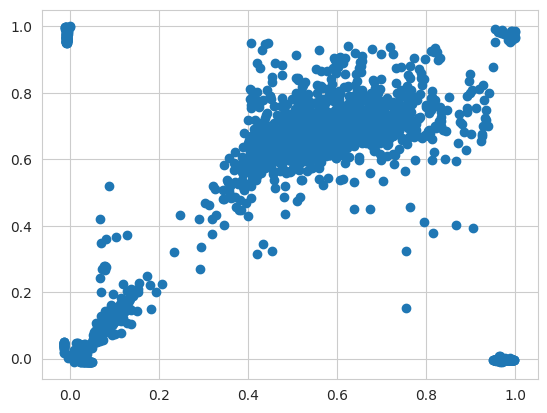

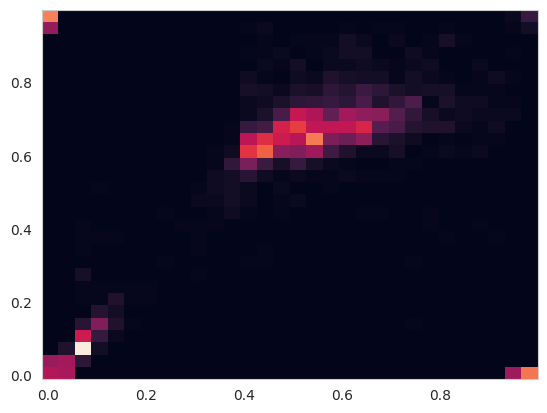

In [24]:
%matplotlib inline
# a = MC.pts[:, 0]
# plt.hist(a[a<0.04], bins=50)

plt.scatter(MC.pts[:, 0], MC.pts[:, 1])
plt.figure()
_ = plt.hist2d(MC.pts[:, 0], MC.pts[:, 1], bins=30)

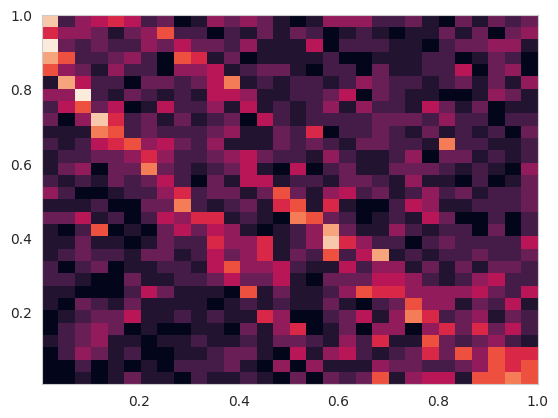

In [42]:
_ = plt.hist2d(pts_cube[:, 0], pts_cube[:, 1], bins=30)

In [45]:
%matplotlib notebook
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.ion()
fig.show()
fig.canvas.draw()

<IPython.core.display.Javascript object>

In [47]:
MC.run_pool(500000, pool_size=15, jobs_per_worker=25, plot_every=23000)

  5%|▍         | 23625/500000 [00:43<12:15, 647.90it/s]../benji_girgs/generation.py:586: RuntimeWarning: divide by zero encountered in true_divide
  puv = np.stack([np.ones(original_edge_dists.shape), const_in * ((wu * wv / W) / original_edge_dists ** d) ** alpha]).min(axis=0)
../benji_girgs/generation.py:587: RuntimeWarning: divide by zero encountered in true_divide
  puv_cube = np.stack([np.ones(cube_edge_dists.shape), const_in * ((wu * wv / W) / cube_edge_dists ** d) ** alpha]).min(axis=0)
500250it [15:37, 533.76it/s]                            


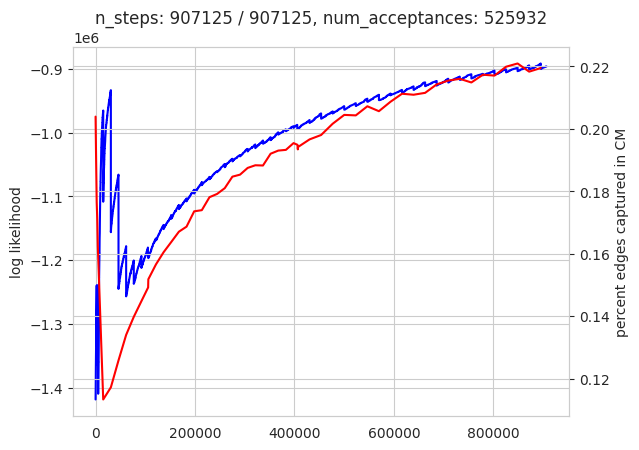

In [52]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

MC.plot_ll(MC.num_steps, CM=True)

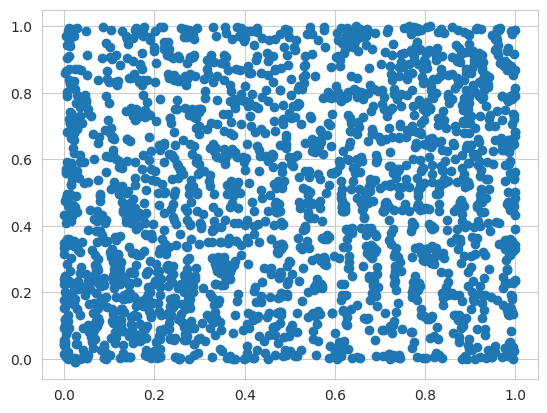

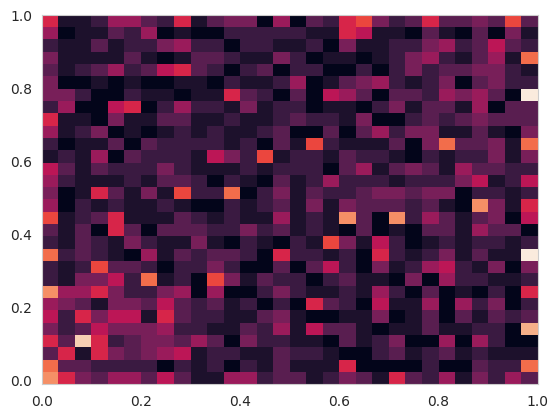

In [48]:
%matplotlib inline
# a = MC.pts[:, 0]
# plt.hist(a[a<0.04], bins=50)

plt.scatter(MC.pts[:, 0], MC.pts[:, 1])
plt.figure()
_ = plt.hist2d(MC.pts[:, 0], MC.pts[:, 1], bins=30)

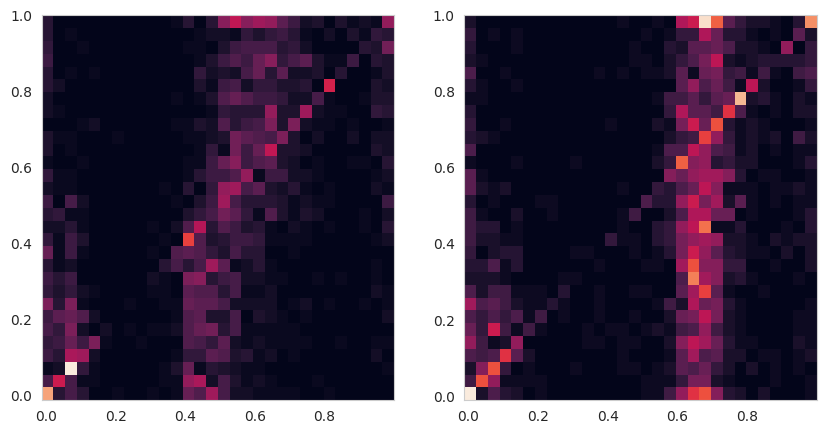

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = ax[0].hist2d(pts[:, 0], MC.pts[:, 0], bins=30)
_ = ax[1].hist2d(pts[:, 1], MC.pts[:, 1], bins=30)

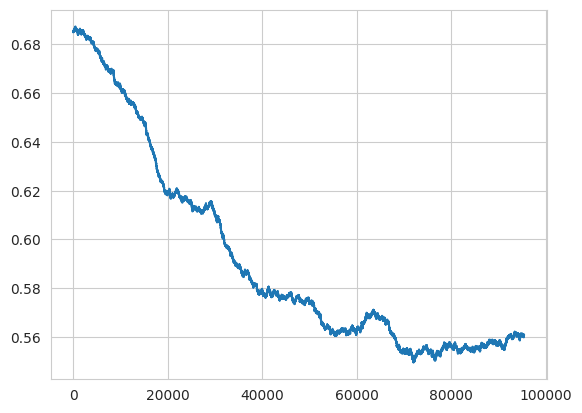

In [28]:
%matplotlib inline
MC.acceptances_plot(convolve_width=10000)

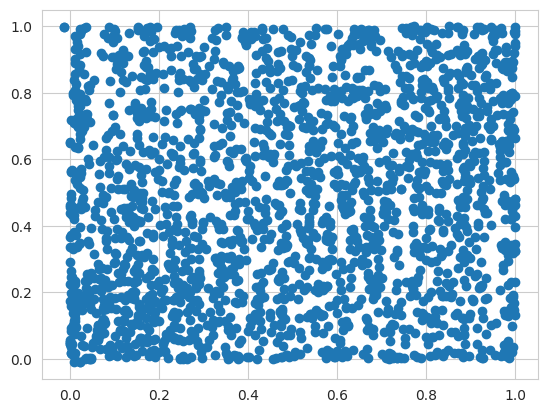

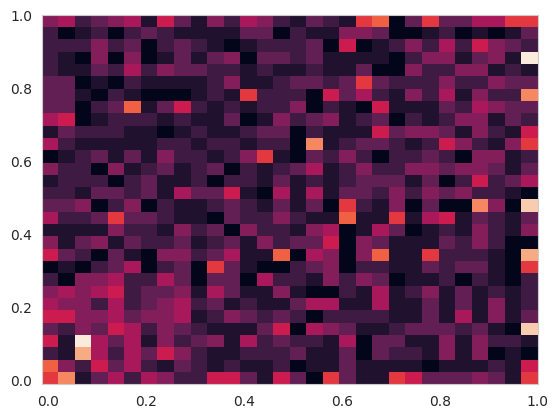

In [39]:
%matplotlib inline
# a = MC.pts[:, 0]
# plt.hist(a[a<0.04], bins=50)

plt.scatter(MC.pts[:, 0], MC.pts[:, 1])
plt.figure()
_ = plt.hist2d(MC.pts[:, 0], MC.pts[:, 1], bins=30)

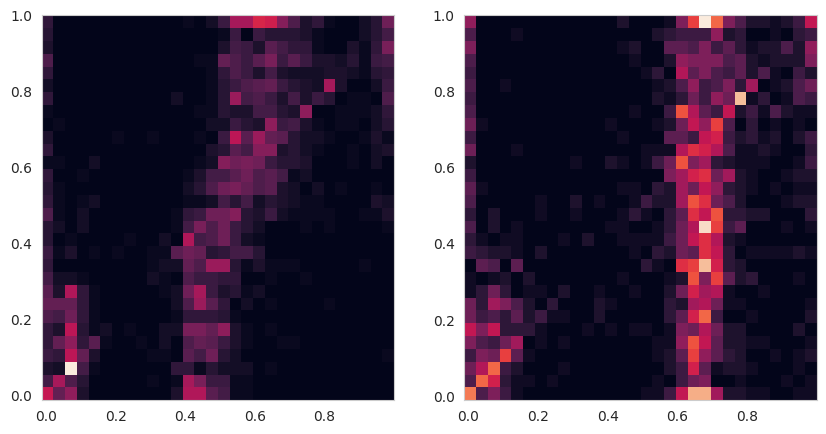

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = ax[0].hist2d(pts[:, 0], MC.pts[:, 0], bins=30)
_ = ax[1].hist2d(pts[:, 1], MC.pts[:, 1], bins=30)

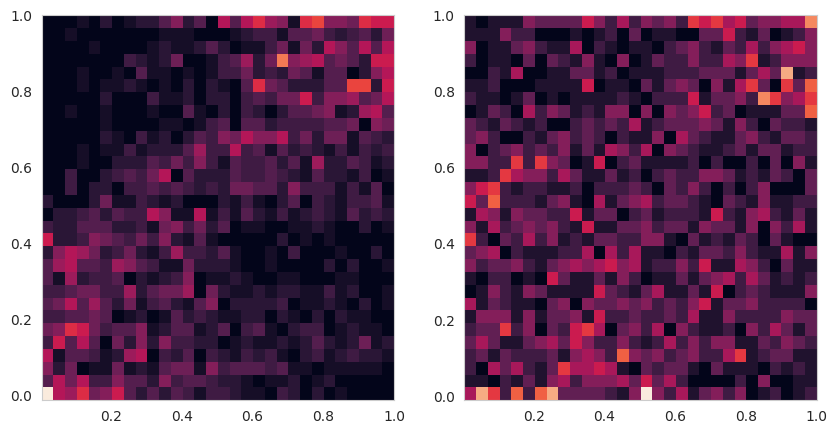

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = ax[0].hist2d(pts_cube[:, 0], MC.pts[:, 0], bins=30)
_ = ax[1].hist2d(pts_cube[:, 1], MC.pts[:, 1], bins=30)

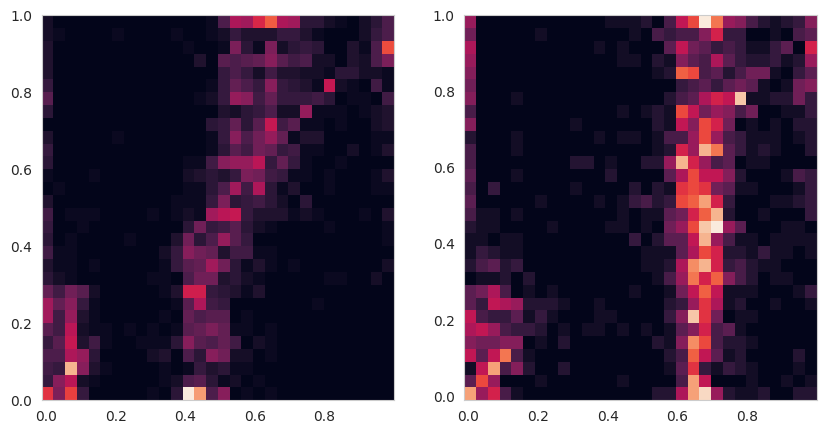

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = ax[0].hist2d(pts[:, 0], MC.pts[:, 0], bins=30)
_ = ax[1].hist2d(pts[:, 1], MC.pts[:, 1], bins=30)

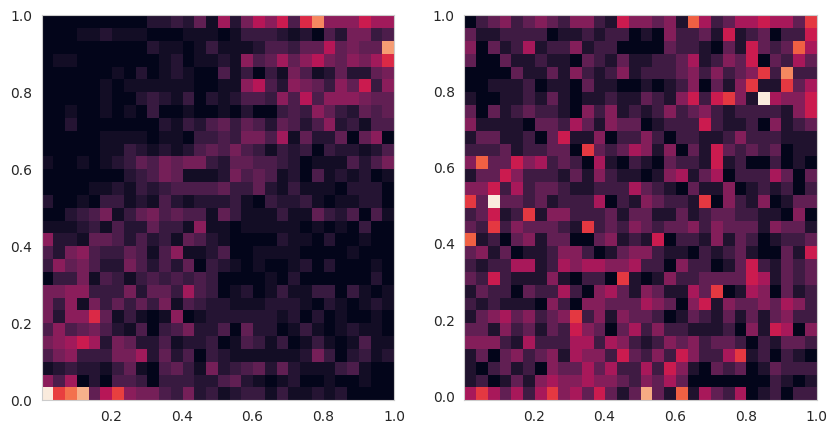

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = ax[0].hist2d(pts_cube[:, 0], MC.pts[:, 0], bins=30)
_ = ax[1].hist2d(pts_cube[:, 1], MC.pts[:, 1], bins=30)

In [18]:
os.environ['DATA_PATH'] = '../../MCMC_testing/'

In [33]:
os.environ['DATA_PATH']

'../../MCMC_testing/'

In [34]:
os.getcwd()

'/cluster/home/bdayan/girgs/benji_src/notebooks'

(array([[ 9.,  6.,  4.,  6.,  4.,  6.,  5.,  3.,  4.,  4.,  2.,  8.,  2.,
          2.,  9.,  2.,  5.,  7.,  5.,  4.,  3.,  7.,  5.,  3.,  2.,  2.,
          5.,  7.,  2.,  9.],
        [ 4.,  6.,  4.,  3.,  4.,  4.,  5.,  2.,  5.,  2.,  5.,  5.,  2.,
          1.,  1.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,  1.,  2.,  1.,  0.,
          0.,  0.,  3.,  2.],
        [ 6.,  7.,  5.,  7.,  2.,  4.,  6.,  7.,  1.,  2.,  1.,  1.,  2.,
          2.,  0.,  1.,  2.,  0.,  0.,  1.,  3.,  2.,  1.,  0.,  2.,  1.,
          2.,  2.,  1.,  5.],
        [ 7.,  2.,  3.,  4.,  2.,  6.,  5.,  1.,  4.,  2.,  4.,  3.,  5.,
          3.,  7.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  3.,  2.,  2.,
          5.,  1.,  4.,  2.],
        [ 7.,  1.,  5.,  3.,  2.,  3.,  4.,  5.,  1.,  3.,  1.,  1.,  1.,
          1.,  1.,  2.,  2.,  3.,  2.,  2.,  1.,  3.,  3.,  2.,  1.,  0.,
          1.,  2.,  2.,  2.],
        [ 5.,  4.,  2.,  7.,  4.,  3.,  3.,  4.,  3.,  3.,  2.,  3.,  1.,
          2.,  1.,  1.,  0.,  1.,  1

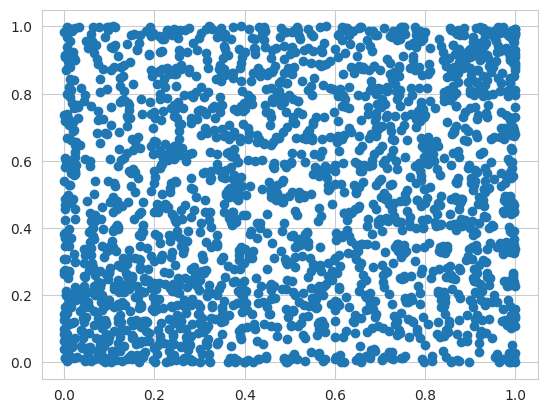

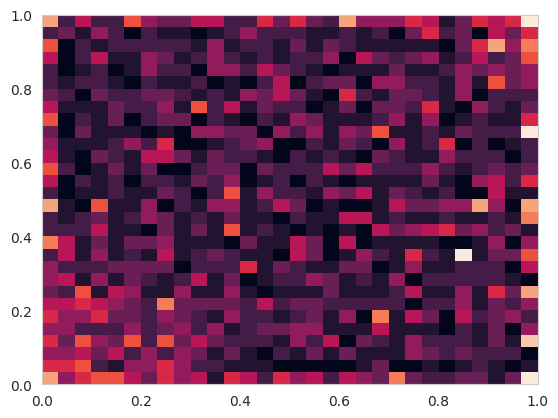

In [61]:
%matplotlib inline
# a = MC.pts[:, 0]
# plt.hist(a[a<0.04], bins=50)

plt.scatter(MC.pts[:, 0], MC.pts[:, 1])
plt.figure()
plt.hist2d(MC.pts[:, 0], MC.pts[:, 1], bins=30)

In [29]:
MC.expected_num_edges

60594.809209926796

In [62]:
g_dm, A_dm = test_mcmc.MC_to_g_A(MC)

out, percent_edges_captured, percent_fake_edges_wrong = mcmc.CM(A, A_dm)
print(out)
print(percent_edges_captured)
print(percent_fake_edges_wrong)


[[42,628 139,280]
 [137,490 4,675,827]]
0.23433823691096597
0.7633329261928291


In [25]:
nk.overview(g_dm)
nk.overview(g)
nk.overview(g_init)

Network Properties:
nodes, edges			1500, 456007
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.405610
clustering coefficient		0.650004
min/max/avg degree		145, 1499, 608.009333
degree assortativity		-0.104838
number of connected components	1
size of largest component	1500 (100.00 %)
Network Properties:
nodes, edges			1500, 60881
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.054153
clustering coefficient		0.526791
min/max/avg degree		9, 1317, 81.174667
degree assortativity		-0.171705
number of connected components	1
size of largest component	1500 (100.00 %)
Network Properties:
nodes, edges			1500, 517006
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.459867
clustering coefficient		0.686715
min/max/avg degree		156, 1499, 689.341333
degree assortativity		-0.118490
number of connected components	1
size of largest component	1500 (100.00 %)


In [34]:
g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
# g_init, A_init = test_mcmc.MC_to_g_A(MC_init)

nk.overview(g_dm)
nk.overview(g_init)

CM = test_mcmc.quick_acc(A, A_dm)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)
':)'

const_in: 0.3975894770262727
Network Properties:
nodes, edges			3745, 134811
directed?			False
weighted?			False
isolated nodes			15
self-loops			0
density				0.019229
clustering coefficient		0.302392
min/max/avg degree		0, 553, 71.995194
degree assortativity		0.107403
number of connected components	16
size of largest component	3730 (99.60 %)
Network Properties:
nodes, edges			3745, 129178
directed?			False
weighted?			False
isolated nodes			10
self-loops			0
density				0.018426
clustering coefficient		0.330564
min/max/avg degree		0, 567, 68.986916
degree assortativity		0.002647
number of connected components	11
size of largest component	3735 (99.73 %)


array([[0.0015478 , 0.01013146],
       [0.01767655, 0.97064419]])

array([[0.13252585, 0.86747415],
       [0.01788543, 0.98211457]])

array([[7.47378347e-04, 1.09318878e-02],
       [1.76736940e-02, 9.70647040e-01]])

array([[0.06399189, 0.93600811],
       [0.01788255, 0.98211745]])

':)'

In [ ]:
MC.plot_ll(MC.num_steps)

In [26]:
MC.calculate_ll()

-1202958.4914603485

In [102]:
MC.ll_steps

[0,
 0,
 1,
 2,
 4,
 5,
 6,
 7,
 12,
 13,
 15,
 16,
 17,
 18,
 23,
 24,
 26,
 27,
 28,
 29,
 31,
 32,
 34,
 36,
 39,
 44,
 45,
 49,
 55,
 57,
 58,
 61,
 67,
 73,
 74,
 78,
 80,
 81,
 82,
 83,
 84,
 86,
 87,
 89,
 91,
 92,
 93,
 94,
 97,
 98,
 99,
 101,
 107,
 112,
 114,
 115,
 116,
 122,
 123,
 124,
 125,
 131,
 134,
 135,
 136,
 137,
 139,
 140,
 142,
 143,
 144,
 145,
 155,
 156,
 157,
 158,
 160,
 161,
 162,
 167,
 168,
 169,
 170,
 172,
 175,
 176,
 177,
 179,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 189,
 190,
 194,
 195,
 198,
 202,
 203,
 204,
 205,
 208,
 211,
 212,
 214,
 215,
 217,
 218,
 219,
 221,
 222,
 226,
 227,
 228,
 229,
 230,
 231,
 233,
 234,
 236,
 237,
 241,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 253,
 256,
 257,
 259,
 263,
 264,
 266,
 267,
 273,
 275,
 276,
 277,
 280,
 285,
 286,
 288,
 289,
 290,
 291,
 297,
 300,
 301,
 302,
 303,
 305,
 307,
 308,
 311,
 312,
 315,
 316,
 319,
 320,
 325,
 326,
 331,
 333,
 340,
 342,
 344,
 345,
 346,
 347,
 34

In [68]:
import pickle
with open('temp.pkl', 'wb') as file:
    pickle.dump(MC, file)

TypeError: gs() missing 1 required positional argument: 'self'

In [67]:
import multiprocessing
import ctypes

def gs(self):
    state = self.__dict__.copy()
    del state['shared_pts']
    del state['shared_pts_init']

def ss(self, state):
    self.__dict__.update(state)
    if self.pool:
        self.shared_pts = multiprocessing.Array(ctypes.c_double, self.pts.flatten())
        self.pts = self.pts_type(np.frombuffer(self.shared_pts.get_obj()).reshape(self.pts.shape))
        self.shared_pts_init = multiprocessing.Array(ctypes.c_double, self.pts_init.flatten())
        self.pts_init = self.pts_type(np.frombuffer(self.shared_pts_init.get_obj()).reshape(self.pts_init.shape))

MC.__getstate__ = gs
MC.__setstate__ = ss

In [81]:
MC.calculate_ll()

-1197406.9692224392

In [77]:
MC.calculate_ll()

-1199493.5638940108

In [44]:
def mcmc_girg_init_worker(pts, pts_shape, pts_init, weights, g):
    mp_var_dict = mcmc.mp_var_dict
    mp_var_dict['pts'] = pts
    mp_var_dict['pts_shape'] = pts_shape
    # mp_var_dict['pts_init'] = None
    if 'pts_init' in mp_var_dict:
        del(mp_var_dict['pts_init'])
    mp_var_dict['weights'] = weights
    mp_var_dict['g'] = g

mcmc.mcmc_girg_init_worker = mcmc_girg_init_worker

In [43]:
foo = {'a': 1}
del(foo['b'])

KeyError: 'b'

In [ ]:

u_index = 100
sigma, p_normal=None, None
if sigma is None:
    sigma = 2 * ((1/n)**1/d)
if p_normal is None:
    p_normal = 0.7

x_u_init = MC.pts_init[u_index]
x_u2 = mcmc.MCMC_girg.proposal(1, d, sigma=sigma, x_u=x_u_init, p_normal=p_normal).squeeze()

def prior_x_u(pt):
    out = p_normal * np.sqrt(1/(2*np.pi) * np.exp(-np.linalg.norm(pt - x_u_init)**2 / (2 * sigma**(2*d))))
    + (1 - p_normal)
    return out
acceptance_prob, u_ll_old, u_ll_new, p_u_to_vs_old, p_u_to_vs_new = mcmc.MCMC_girg.acceptance_prob_static(MC.g, weights, alpha, MC.const_in, MC.pts,
                                                                                    u_index, x_u2, prior_x_u)

In [36]:
x_u2
x_u_init

PointsCube([0.06785322, 0.98485106])

PointsCube([0.06993552, 0.98693336])

In [38]:
prior_x_u(x_u_init)
prior_x_u(x_u2)

0.2792595962810029

0.01796251693731934

In [39]:
pts = MC.pts
eps = 1e-7
p_u_to_vs = generation.get_probs_u(weights, MC.pts, alpha, MC.const_in, u_index)
p_u_to_vs = np.clip(p_u_to_vs, eps, 1 - eps)

x_u = pts[u_index].copy()
pts[u_index] = x_u2
p_u_to_vs2 = generation.get_probs_u(weights, MC.pts, alpha, MC.const_in, u_index)
pts[u_index] = x_u
p_u_to_vs2 = np.clip(p_u_to_vs2, eps, 1 - eps)

u_ll_old = mcmc.MCMC_girg.p_u_to_vs_to_ll(g, u_index, p_u_to_vs)
u_ll_new = mcmc.MCMC_girg.p_u_to_vs_to_ll(g, u_index, p_u_to_vs2)

In [41]:
u_ll_old
u_ll_new

-28842.560305343573

-29101.628442570873

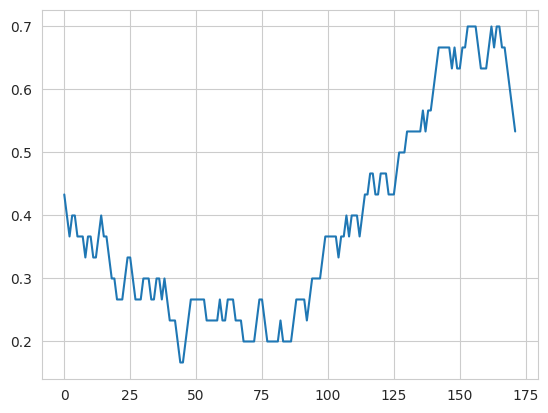

In [37]:
%matplotlib inline
MC.acceptances_plot(convolve_width=30)

In [48]:
g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
CM = test_mcmc.quick_acc(A, A_dm)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)
':)'

const_in: 7.903612372398382e-06


array([[0.00569284, 0.02764484],
       [0.02499793, 0.9416644 ]])

array([[0.17076292, 0.82923708],
       [0.02586004, 0.97413996]])

array([[0.00325768, 0.03008   ],
       [0.04177225, 0.92489007]])

array([[0.09771763, 0.90228237],
       [0.04321286, 0.95678714]])

':)'

(0.05, 0.12)

(0.8, 1.0)

<Figure size 640x480 with 0 Axes>

(0.06, 0.08)

(0.875, 1.0)

<Figure size 640x480 with 0 Axes>

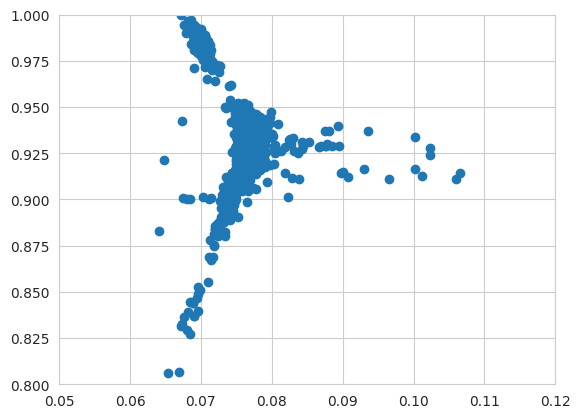

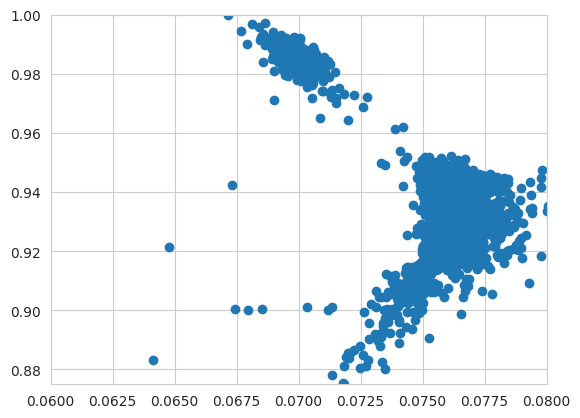

<Figure size 640x480 with 0 Axes>

In [51]:
%matplotlib inline
plt.scatter(MC.pts[:, 0], MC.pts[:, 1])
plt.xlim([0.05, 0.12])
plt.ylim([0.8, 1.0])
plt.figure()

plt.scatter(MC.pts[:, 0], MC.pts[:, 1])
plt.xlim([0.06, 0.08])
plt.ylim([0.875, 1.0])
plt.figure()

# plt.hist2d(MC.pts[:, 0], MC.pts[:, 1], bins=1000)
# plt.xlim([0.06, 0.09])
# plt.ylim([0.0, 0.2])

(array([277., 194., 210., 217., 244., 223., 230., 223., 205., 227.]),
 array([0.        , 0.09999247, 0.19998495, 0.29997742, 0.3999699 ,
        0.49996237, 0.59995485, 0.69994732, 0.7999398 , 0.89993227,
        0.99992474]),
 <BarContainer object of 10 artists>)

<Figure size 640x480 with 0 Axes>

(array([252., 203., 214., 247., 237., 234., 221., 202., 216., 224.]),
 array([0.        , 0.09990712, 0.19981424, 0.29972137, 0.39962849,
        0.49953561, 0.59944273, 0.69934986, 0.79925698, 0.8991641 ,
        0.99907122]),
 <BarContainer object of 10 artists>)

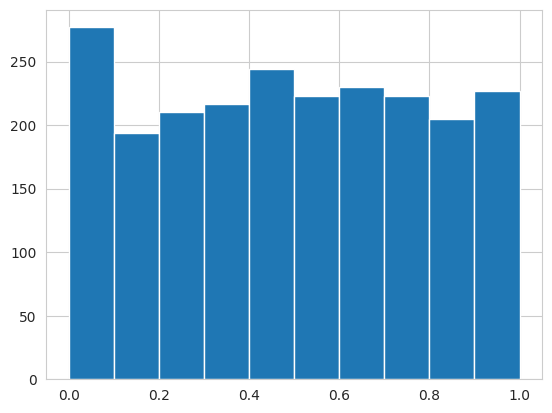

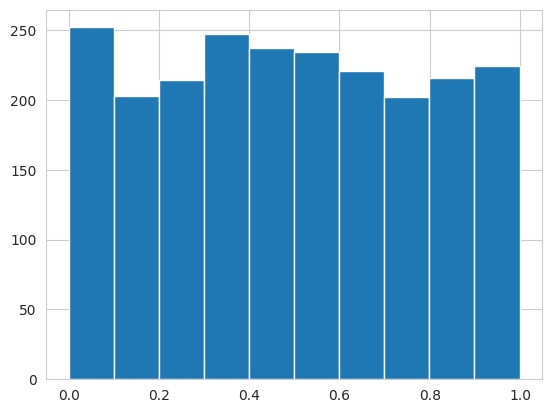

In [52]:
%matplotlib inline
plt.hist(MC.pts[:, 0])
plt.figure()
plt.hist(MC.pts[:, 1])


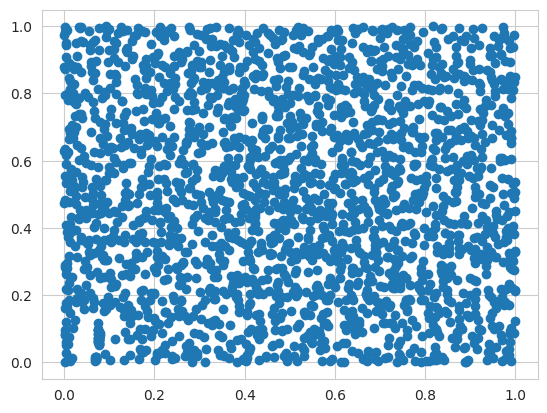

In [53]:
plt.scatter(MC.pts[:, 0], MC.pts[:, 1])

In [16]:
g_mc, A_mc = test_mcmc.MC_to_g_A(MC)
nk.overview(g_mc)

const_in: 0.17931646322859224
Network Properties:
nodes, edges			2250, 75074
directed?			False
weighted?			False
isolated nodes			14
self-loops			0
density				0.029672
clustering coefficient		0.313861
min/max/avg degree		0, 449, 66.732444
degree assortativity		0.071144
number of connected components	15
size of largest component	2236 (99.38 %)


In [17]:
CM = test_mcmc.quick_acc(A, A_mc)
CM
test_mcmc.quick_summarise_CM(CM)

CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)

':('

array([[0.0024798 , 0.03085788],
       [0.02717906, 0.93948326]])

array([[0.07438438, 0.92561562],
       [0.0281164 , 0.9718836 ]])

':('

In [9]:
a = df.loc[:, ['Graph', 'Model', 'Nodes', 'Info']]
a

,Graph,Model,Nodes,Info
0,socfb-Caltech36,1d-copyweight-cube-girg,756,"{'tau': 7.3017225936374555, 'alpha': 1.2171928..."
1,socfb-Reed98,1d-copyweight-cube-girg,955,"{'tau': 4.381732472502371, 'alpha': 1.07671601..."
2,socfb-Caltech36,2d-copyweight-cube-girg,757,"{'tau': 7.3017225936374555, 'alpha': 1.1949215..."
3,socfb-Simmons81,1d-copyweight-cube-girg,1497,"{'tau': 4.739342146243066, 'alpha': 1.16300199..."
4,socfb-Haverford76,1d-copyweight-cube-girg,1440,"{'tau': 6.5461700448727616, 'alpha': 1.0592519..."
...,...,...,...,...
157,socfb-Bingham82,2d-copyweight-cube-girg,9945,"{'tau': 5.959769046529775, 'alpha': 1.07671601..."
158,socfb-Maine59,3d-copyweight-cube-girg,9001,"{'tau': 5.253031117549527, 'alpha': 1.10401932..."
159,socfb-Mississippi66,2d-copyweight-cube-girg,10496,"{'tau': 5.425199038576664, 'alpha': 1.05073058..."
160,socfb-Georgetown15,3d-copyweight-cube-girg,9341,"{'tau': 4.898184083615165, 'alpha': 1.04234527..."


In [21]:
a.loc[a.Graph == 'socfb-Pepperdine86']

,Graph,Model,Nodes,Info
41,socfb-Pepperdine86,1d-copyweight-cube-girg,3430,"{'tau': 5.27297948141534, 'alpha': 1.059251903..."
53,socfb-Pepperdine86,2d-copyweight-cube-girg,3426,"{'tau': 5.27297948141534, 'alpha': 1.025969862..."
67,socfb-Pepperdine86,3d-copyweight-cube-girg,3430,"{'tau': 5.27297948141534, 'alpha': 1.010101010..."


In [22]:
df.iloc[41].Info

{'tau': 5.27297948141534,
 'alpha': 1.0592519033432637,
 'const': 0.10914879350912529,
 'target_lcc': 0.27697571394183823,
 'fit_lcc': 0.2790005420603239,
 'fitting_time': 180.74201369285583,
 'hist': [(2.0, 0.614930496642529),
  (1.342281879194631, 0.42023462193045735),
  (1.1527377521613833, 0.3257112505037432),
  (1.0767160161507403, 0.2855294469587692),
  (1.0423452768729642, 0.26787251887177715),
  (1.0592519033432637, 0.2766223208246902),
  (1.0679125646587686, 0.28514010229395503),
  (1.0592519033432637, 0.2766223208246902)]}

In [23]:
df.iloc[53].Info

{'tau': 5.27297948141534,
 'alpha': 1.0259698621353,
 'const': 0.059451413878825084,
 'target_lcc': 0.27697571394183823,
 'fit_lcc': 0.2748780151815607,
 'fitting_time': 289.33652424812317,
 'hist': [(2.0, 0.5849583176785574),
  (1.342281879194631, 0.4251694982750488),
  (1.1527377521613833, 0.3434494442734461),
  (1.0767160161507403, 0.30518489387359304),
  (1.0423452768729642, 0.2834073963759906),
  (1.0259698621353, 0.274660388413119),
  (1.0340927451930846, 0.28050691796757915),
  (1.0259698621353, 0.274660388413119)]}

In [32]:
import importlib
importlib.reload(test_mcmc)

<module 'tests.test_mcmc' from '../tests/test_mcmc.py'>

In [31]:
# gd = do_feature_extract.graph_dicts[21]

gd = list(filter(lambda x: x['Name'] == 'socfb-Pepperdine86', do_feature_extract.graph_dicts))[0]

in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
nk.overview(g)
n = g.numberOfNodes()

alpha = df.iloc[53].Info['alpha']
const = df.iloc[53].Info['const']

'/cluster/scratch/bdayan/GIRG_data/socfb-Pepperdine86.SpaceOne'

Network Properties:
nodes, edges			3440, 152003
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.025698
clustering coefficient		0.276976
min/max/avg degree		1, 674, 88.373837
degree assortativity		0.055527
number of connected components	1
size of largest component	3440 (100.00 %)


In [33]:
g, A, weights, const, pts_diffmap, pts_init, MC, MC_init = test_mcmc.test_diffmap_on_g(g, alpha=alpha, const=const, pts_d=2)

../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(wuwv, dists**d)


In [34]:
g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
g_init, A_init = test_mcmc.MC_to_g_A(MC_init)
nk.overview(g_dm)
nk.overview(g_init)

CM = test_mcmc.quick_acc(A, A_dm)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)
':)'


const_in: 0.22909876856987865


../benji_girgs/generation.py:65: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(outer, dists**d)
../benji_girgs/generation.py:442: RuntimeWarning: divide by zero encountered in true_divide
  puv = np.stack([np.ones(original_edge_dists.shape), const_in * ((wu * wv / W) / original_edge_dists ** d) ** alpha]).min(axis=0)
../benji_girgs/generation.py:443: RuntimeWarning: divide by zero encountered in true_divide
  puv_cube = np.stack([np.ones(cube_edge_dists.shape), const_in * ((wu * wv / W) / cube_edge_dists ** d) ** alpha]).min(axis=0)


const_in: 0.22909876856987865
Network Properties:
nodes, edges			3440, 2987323
directed?			False
weighted?			False
isolated nodes			12
self-loops			0
density				0.505035
clustering coefficient		0.841734
min/max/avg degree		0, 2699, 1736.815698
degree assortativity		0.354706
number of connected components	13
size of largest component	3428 (99.65 %)
Network Properties:
nodes, edges			3440, 152170
directed?			False
weighted?			False
isolated nodes			15
self-loops			0
density				0.025726
clustering coefficient		0.276121
min/max/avg degree		0, 404, 88.470930
degree assortativity		0.041911
number of connected components	16
size of largest component	3425 (99.56 %)


array([[0.0238051 , 0.00188497],
       [0.48108319, 0.49322674]])

array([[0.92662645, 0.07337355],
       [0.49376812, 0.50623188]])

array([[0.00170988, 0.02398019],
       [0.02400842, 0.95030151]])

array([[0.0665579 , 0.9334421 ],
       [0.02464146, 0.97535854]])

':)'

In [ ]:
MC.run_pool(20000, pool_size=15, jobs_per_worker=15, plot_every=20)

In [4]:
from tests import test_mcmc
from tests.test_mcmc import *
import importlib
importlib.reload(test_mcmc)
g, A, weights, const, pts, pts_diffmap, pts_init, MC, MC_init, MC_cheat = test_mcmc.test_diffmap()

g_dm, A_dm = test_mcmc.MC_to_g_A(MC)
g_init, A_init = test_mcmc.MC_to_g_A(MC_init)
g_cheat, A_cheat = test_mcmc.MC_to_g_A(MC_cheat)


<module 'tests.test_mcmc' from '../tests/test_mcmc.py'>

const_in: 21.744500891857935


../benji_girgs/generation.py:65: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(outer, dists**d)
../benji_girgs/generation.py:442: RuntimeWarning: divide by zero encountered in true_divide
  puv = np.stack([np.ones(original_edge_dists.shape), const_in * ((wu * wv / W) / original_edge_dists ** d) ** alpha]).min(axis=0)
../benji_girgs/generation.py:443: RuntimeWarning: divide by zero encountered in true_divide
  puv_cube = np.stack([np.ones(cube_edge_dists.shape), const_in * ((wu * wv / W) / cube_edge_dists ** d) ** alpha]).min(axis=0)
../benji_girgs/generation.py:78: RuntimeWarning: divide by zero encountered in true_divide
  p_uv = np.divide(wuwv, dists**d)


const_in: 21.744500891857935
const_in: 21.744500891857935
const_in: 21.744500891857935


In [6]:
(const*2)**alpha

21.744500891857935

In [7]:
g_temp, _, _, _, _ = generation.generate_GIRG_nk(n, d, tau, alpha, weights=weights, pts=pts, const=const)

const_in: 21.744500891857935


In [8]:
const

6.507705243675296

In [9]:
pts

PointsCube([[0.63956876],
            [0.20144225],
            [0.07984331],
            ...,
            [0.88855468],
            [0.70501783],
            [0.04734976]])

In [10]:
nk.overview(g)
nk.overview(g_temp)

Network Properties:
nodes, edges			1500, 70397
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.062617
clustering coefficient		0.563041
min/max/avg degree		21, 1499, 93.862667
degree assortativity		-0.199725
number of connected components	1
size of largest component	1500 (100.00 %)
Network Properties:
nodes, edges			1500, 70327
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.062555
clustering coefficient		0.562545
min/max/avg degree		18, 1499, 93.769333
degree assortativity		-0.199262
number of connected components	1
size of largest component	1500 (100.00 %)


In [11]:
nk.overview(g_cheat)

Network Properties:
nodes, edges			1500, 70672
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.062861
clustering coefficient		0.560786
min/max/avg degree		21, 1499, 94.229333
degree assortativity		-0.199488
number of connected components	1
size of largest component	1500 (100.00 %)


In [12]:
nk.overview(g_dm)

Network Properties:
nodes, edges			1500, 77445
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.068886
clustering coefficient		0.570072
min/max/avg degree		10, 1499, 103.260000
degree assortativity		-0.197577
number of connected components	1
size of largest component	1500 (100.00 %)


In [18]:
CM = test_mcmc.quick_acc(A, A_cheat)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_dm)
CM
test_mcmc.quick_summarise_CM(CM)
print('============')
CM = test_mcmc.quick_acc(A, A_init)
CM
test_mcmc.quick_summarise_CM(CM)


array([[0.03788   , 0.02469511],
       [0.02493956, 0.91248533]])

array([[0.6053525 , 0.3946475 ],
       [0.02660432, 0.97339568]])

array([[0.03113422, 0.03144089],
       [0.03770578, 0.89971911]])

array([[0.49754961, 0.50245039],
       [0.04022272, 0.95977728]])

array([[0.01840444, 0.04417067],
       [0.04421867, 0.89320622]])

array([[0.29411765, 0.70588235],
       [0.04717036, 0.95282964]])

In [20]:
np.where(A[0, :])

(array([   7,   15,   17,   20,   23,   38,   53,   75,   77,   86,   88,
          89,  113,  141,  166,  176,  216,  224,  247,  251,  252,  271,
         272,  279,  310,  320,  345,  347,  371,  379,  392,  419,  440,
         447,  452,  456,  469,  488,  493,  505,  522,  526,  545,  559,
         572,  574,  606,  612,  614,  621,  625,  643,  648,  653,  658,
         667,  673,  682,  717,  721,  736,  761,  762,  774,  782,  786,
         805,  817,  835,  837,  844,  849,  897,  900,  904,  917,  929,
         932,  941,  943,  949,  956,  960,  964,  968,  978,  997,  999,
        1017, 1019, 1053, 1062, 1087, 1097, 1100, 1117, 1135, 1140, 1150,
        1163, 1165, 1169, 1170, 1183, 1184, 1216, 1228, 1241, 1252, 1269,
        1284, 1321, 1326, 1338, 1345, 1362, 1382, 1383, 1391, 1397, 1402,
        1422, 1477, 1486]),)

In [14]:
list(g.iterNeighbors(0))

[18,
 66,
 98,
 116,
 169,
 176,
 187,
 198,
 260,
 302,
 311,
 343,
 361,
 367,
 1492,
 403,
 413,
 445,
 446,
 456,
 467,
 475,
 476,
 514,
 520,
 523,
 529,
 541,
 576,
 607,
 614,
 662,
 689,
 700,
 717,
 722,
 754,
 769,
 801,
 808,
 841,
 848,
 884,
 888,
 900,
 903,
 913,
 917,
 923,
 938,
 984,
 986,
 991,
 1006,
 1009,
 1015,
 1021,
 1034,
 1041,
 1042,
 1050,
 1051,
 1071,
 1104,
 1114,
 1169,
 1177,
 1179,
 1189,
 1234,
 1235,
 1255,
 1265,
 1297,
 1301,
 1317,
 1333,
 1344,
 1395,
 1438,
 1449,
 1454,
 1456,
 1459,
 1470,
 1472]

In [15]:
list(g_temp.iterNeighbors(0))

[18,
 66,
 75,
 86,
 98,
 116,
 126,
 169,
 173,
 176,
 192,
 194,
 198,
 212,
 229,
 256,
 260,
 302,
 311,
 343,
 361,
 362,
 367,
 403,
 413,
 433,
 446,
 456,
 467,
 476,
 514,
 517,
 521,
 523,
 529,
 607,
 613,
 648,
 692,
 712,
 714,
 722,
 740,
 754,
 764,
 801,
 836,
 841,
 884,
 888,
 900,
 929,
 950,
 984,
 986,
 991,
 1006,
 1050,
 1051,
 1065,
 1071,
 1104,
 1114,
 1169,
 1179,
 1189,
 1198,
 1218,
 1234,
 1235,
 1257,
 1301,
 1313,
 1317,
 1340,
 1344,
 1361,
 1413,
 1434,
 1438,
 1449,
 1454,
 1456,
 1498]

In [16]:
len(list(g_temp.iterNeighbors(0)))
len(list(g.iterNeighbors(0)))

84

86

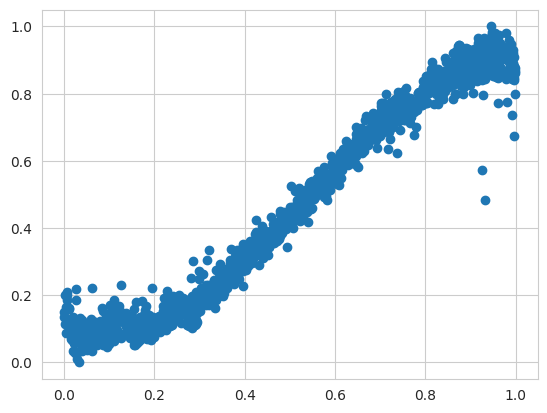

In [6]:
plt.scatter(pts[:, 0], pts_diffmap[:, 0])

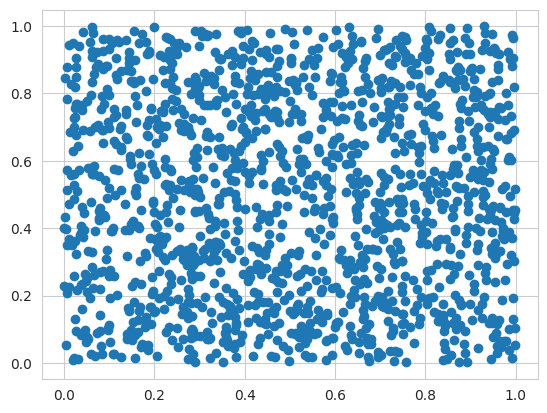

In [7]:
plt.scatter(pts[:, 0], pts_init[:, 0])